$$\newcommand{\Rv}{\mathbf{R}}
\newcommand{\rv}{\mathbf{r}}
\newcommand{\Qv}{\mathbf{Q}}
\newcommand{\Qnv}{\mathbf{Qn}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\Aiv}{\mathbf{Ai}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\TDv}{\mathbf{TD}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

# A5 Reinforcement Learning Robot

In this assignment, you will train a neural network to approximate the Q function for a simple simulation of a two-dimensional robot.  

The simulation of the robot is just a little more complicated than the dynamic marble we used in lecture. As before, we define the ```reinforcement```, ```initial_state```, and ```next_state``` functions to specify our dynamic marble problem.

In [115]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks_A4 as nn
import copy
import sys
from math import pi

from IPython.display import display, clear_output

First, here is a python class that defines our robot.

## The Robot

In [116]:
import itertools

class Robot():

    def __init__(self, link_lengths, rects):
        self.n_links = len(link_lengths)
        self.rects = rects
        self.n_rects = len(rects)
        self.record_angles = False
        self.angles = []
        self.link_lengths = np.array(link_lengths)
        self.joint_angles = np.zeros(self.n_links)
        self.points = [[10, 10] for _ in range(self.n_links + 1)]
        self.lim = sum(link_lengths)
        self.update_points()
        self.valid_actions = np.array(list(itertools.product(*[[-0.1, 0, 0.1]] * self.n_links)))
        self.goal_radius = 2
        
    def __repr__(self):
        return f'Robot({self.link_lengths}, {self.rects}'

    def set_goal(self, g):
        self.goal = g
        
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.update_points()

    def add_to_joints(self, joint_angle_deltas):
        self.joint_angles += joint_angle_deltas
        too_high = self.joint_angles > 2 * pi
        self.joint_angles[too_high] = self.joint_angles[too_high] - 2 * pi
        too_low = self.joint_angles < 0
        self.joint_angles[too_low] = self.joint_angles[too_low] + 2 * pi
        
        if self.record_angles:
            self.angles.append(self.joint_angles * 180 / pi)

        self.update_points()

    def update_points(self):
        for i in range(1, self.n_links + 1):
            self.points[i][0] = self.points[i - 1][0] + \
                self.link_lengths[i - 1] * \
                np.cos(np.sum(self.joint_angles[:i]))
            self.points[i][1] = self.points[i - 1][1] + \
                self.link_lengths[i - 1] * \
                np.sin(np.sum(self.joint_angles[:i]))

        self.end_effector = np.array(self.points[self.n_links]).T

    def get_state(self):
        return np.hstack((np.sin(self.joint_angles),
                          np.cos(self.joint_angles)))

    def plot(self, obstacles=[]):  # pragma: no cover
        for rect in self.rects:
            patch = plt.Rectangle(rect[:2], rect[2], rect[3])
            plt.gca().add_patch(patch)

        plt.gca().add_patch(plt.Circle(self.goal[:2], radius=self.goal_radius, fc='g'))

        for i in range(self.n_links + 1):
            if i is not self.n_links:
                plt.plot([self.points[i][0], self.points[i + 1][0]],
                         [self.points[i][1], self.points[i + 1][1]], 'r-')
            plt.plot(self.points[i][0], self.points[i][1], 'k.')
        
        plt.axis('square')
        plt.xlim([-1, 21])
        plt.ylim([-1, 21])
        # plt.pause(1e-2)

    
    def line_rect_collision(self, line, rect):
        '''line = [x1, y1, x2, y2], rect = [rx, ry, w, h]'''    

        x1, y1, x2, y2 = line
        rx, ry, w, h = rect

        if ((y1 > ry + h and y2 > ry + h) or
            (y1 < ry and y2 < ry) or
            (x1 > rx + w and x2 > rx + w) or
            (x1 < rx and x2 < rx)):
            return False

        dx = x2 - x1

        dy = y2 - y1

        if abs(dx) > 10 * sys.float_info.min:
            left_y = y1 + (rx - x1) / dx * dy
        else:
            left_y = y1
        # print(f'left_y {left_y} ry {ry} ry+h {ry+h}')
        if ry <= left_y <= ry + h:
            return True

        if abs(dx) > 10 * sys.float_info.min:
            right_y = y1 + (rx + w - x1) / dx * dy
        else:
            right_y = y1
        # print(f'right_y {right_y}')
        if ry <= right_y <= ry + h:
            return True

        if abs(dy) > 10 * sys.float_info.min:
            bottom_x = x1 + (ry - y1) / dy * dx
        else:
            bottom_x = x1
        # print(f'bottom_x {bottom_x}')
        if rx <= bottom_x <= rx + w:
            return True

        if abs(dy) > 10 * sys.float_info.min:
            top_x = x1 + (ry + h - y1) / dy * dx
        else:
            top_x = x1

        if rx <= top_x <= rx + w:
            return True

        return False

    def collision(self):
        for i in range(len(self.points) - 1):
            line = self.points[i] + self.points[i + 1]
            for rect in self.rects:
                if self.line_rect_collision(line, rect):
                    return True
        return False

    def illustrate(self):
        fig = plt.figure(figsize=(8, 8))
        self.update_joints(np.random.uniform(-pi, pi, self.n_links))
        for i in range(100):
            action = np.random.choice([-0.2, 0, 0.2], size=self.n_links)
            self.add_to_joints(action)
            fig.clf()
            self.plot()
            if self.collision():
                break
            clear_output(wait=True)
            display(fig)
    
        clear_output(wait=True)

To create an instance of our `Robot`, we first need to define a set of obstacles as rectangles.  Here is an example of one rectangle.  The range of our robot's two-dimensional space is 20 x 20.

For example, here is one obstacle with lower left corner at (13, 7) and a width and height of 2.

In [117]:
obstacles = np.array([[13, 7, 2, 2]])

To define our robot, we provide the lengths of each link in the robot arm, and also provide the obstacles.  A three-link robot arm with lengths 4, 4, and 2 is defined here.

In [147]:
robot = Robot([6, 6], obstacles)
robot

Robot([6 6], [[13  7  2  2]]

Now we need to specify the goal position for the end point of our robot.  The base of our robot is always at (10, 10).  Let's set the goal to be at position (18, 5).  The end of the robot has to be within a radius of 2 of the goal position to succeed.


In [148]:
robot.set_goal( np.array([18, 5]) )

This class includes a handy function named `illustrate` that displays the behavior of our robot.

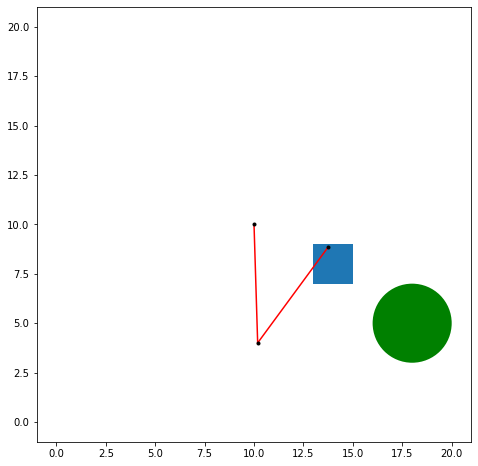

In [149]:
robot.illustrate()

The state of the robot is given by its joint angles.  To allow an angle at 360 degrees or 2$\pi$ radians and 0 degrees of 0 radians to be treated the same by our Q network, we represent each angle by the sine and cosine of the angle.  So, for three links our state consists of three sine values followed by three cosine values.  

In [150]:
robot.get_state()

array([-0.9995252 ,  0.6168344 ,  0.03081177, -0.78709296])

The number of action components is two, one for each joint angle.

In [151]:
robot.valid_actions

array([[-0.1, -0.1],
       [-0.1,  0. ],
       [-0.1,  0.1],
       [ 0. , -0.1],
       [ 0. ,  0. ],
       [ 0. ,  0.1],
       [ 0.1, -0.1],
       [ 0.1,  0. ],
       [ 0.1,  0.1]])

## Reinforcement Learning Agent

In [216]:
def dist(a, b):
    return np.sqrt(np.sum((a - b)**2))

def reinforcement(robot):  # next state
    robot.goal_achieved = False
    if robot.collided:
        r = -1
    else:
        dist_to_goal = dist(robot.goal, robot.end_effector)
        if dist_to_goal < robot.goal_radius:
            r = 5
            robot.goal_achieved = True
        else:
            # r = 0
            r =  -dist_to_goal/ 50
    return r

def initial_state(robot):
    # continue generating initial random joint angles until no initial collision
    collide = True
    while collide:
        robot.update_joints(np.random.uniform(-pi, pi, robot.n_links))
        collide = robot.collision()
        robot.collided = False
        robot.goal_achieved = False
        state = robot.get_state()
        return state

def next_state(state, action):
    old_state = copy.copy(state)
    robot.add_to_joints(action)
    state = robot.get_state()
    robot.collided = robot.collision()
    return state

def epsilon_greedy(robot, Qnet, state, epsilon):
    n_valid_actions = len(robot.valid_actions)
    if np.random.uniform() < epsilon:
        # Random Move
        rows = np.arange(n_valid_actions)
        actioni = np.random.randint(n_valid_actions)
        action = robot.valid_actions[actioni]
    else:
        # Greedy Move
        action_rows = np.arange(n_valid_actions)
        np.random.shuffle(action_rows)
        Qs = [Qnet.use(np.hstack((state, a)).reshape((1, -1))) for a in robot.valid_actions[action_rows]]
        ai = np.argmax(Qs)
        action = robot.valid_actions[action_rows[ai]]
    Q = Qnet.use(np.hstack((state, action)). reshape((1, -1)))

    return action, Q

def make_samples(robot, Qnet, initial_state_f, next_state_f, reinforcement_f, n_samples, epsilon):

    X = np.zeros((n_samples, Qnet.n_inputs))
    R = np.zeros((n_samples, 1))
    next_Q = np.zeros((n_samples, 1))
    
    robot.collided = True  # to force reset to new state in following loop
    
    for step in range(n_samples):

        if robot.collided or robot.goal_achieved:
            state = initial_state_f(robot)
            state = next_state_f(state, 0)
            action, _ = epsilon_greedy(robot, Qnet, state, epsilon)
            
        next_state = next_state_f(state, action)
        r = reinforcement_f(robot)
        next_action, Q = epsilon_greedy(robot, Qnet, next_state, epsilon)
        X[step, :] = np.hstack((state, action))
        R[step, 0] = r
        next_Q[step, 0] = 0 if robot.collided or robot.goal_achieved else Q  # 0 if no future
        state, action = next_state, next_action

    return (X, R, next_Q)

def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.X_means = np.array(Xmeans)
    Qnet.X_stds = np.array(Xstds)
    Qnet.T_means = np.array(Tmeans)
    Qnet.T_stds = np.array(Tstds)

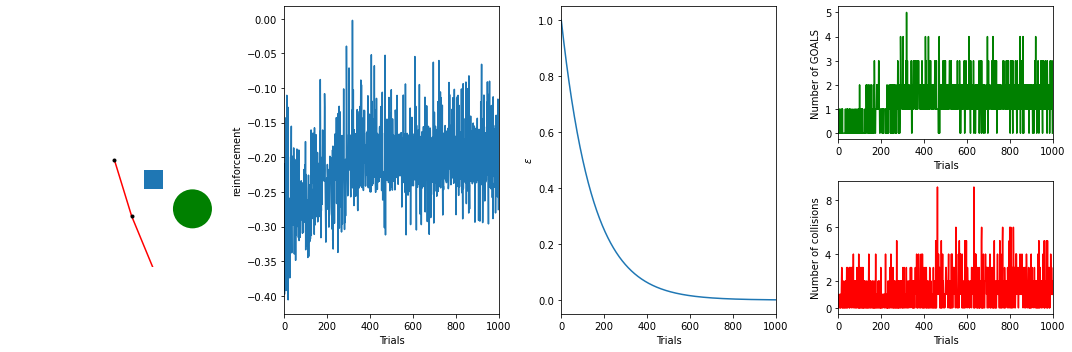

In [217]:
fig = plt.figure(figsize=(15, 5))

gamma = 0.8
n_trials = 1000
n_steps_per_trial = 100 
n_epochs = 20
learning_rate = 0.01
epsilon = 1
final_epsilon = 0.001
epsilon_decay =  np.exp(np.log(final_epsilon) / (n_trials))

epsilon_trace = np.zeros(n_trials)
r_trace = np.zeros(n_trials)
goal_reached = np.zeros(n_trials)
collisions = np.zeros(n_trials)

nh = [50, 50, 20, 10]  # hidden layers structure
n_links = robot.n_links
Qnet = nn.NeuralNetwork(2 * n_links + n_links, nh, 1) 

setup_standardization(Qnet, 
                      [0, 0] * n_links + [0] * n_links, 
                      [1, 1] * n_links + [0.01] * n_links,
                      [0], [0.1])


for trial in range(n_trials):
    
    X, R, Qn = make_samples(robot, Qnet, initial_state, next_state, reinforcement,
                            n_steps_per_trial, epsilon)
    
    Qnet.train(X, R + gamma * Qn, n_epochs,  method='adam', learning_rate=learning_rate, batch_size=-1, verbose=False)

    # Rest is for plotting
    epsilon_trace[trial] = epsilon
    epsilon *= epsilon_decay
    r_trace[trial] = np.mean(R)
    goal_reached[trial] = np.sum(R == 5)
    collisions[trial] = np.sum(R == -1)
    
    if True and (trial + 1 == n_trials or trial % (n_trials / 20) == 0):
        fig.clf()
        plt.subplot(1, 4, 1)
        robot.plot()
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.plot(r_trace[:trial])
        plt.ylabel('reinforcement')
        plt.xlabel('Trials')
        plt.xlim(0, n_trials)
        plt.subplot(1, 4, 3)
        plt.plot(epsilon_trace[:trial])
        plt.ylabel('$\epsilon$')
        plt.xlabel('Trials')
        plt.xlim(0, n_trials)
        plt.subplot(2, 4, 4)
        plt.plot(goal_reached[:trial], 'g')
        plt.ylabel('Number of GOALS')
        plt.xlabel('Trials')
        plt.xlim(0, n_trials)
        plt.subplot(2, 4, 8)
        plt.plot(collisions[:trial], 'r')
        plt.ylabel('Number of collisions')
        plt.xlabel('Trials')
        plt.xlim(0, n_trials)
        plt.tight_layout()
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


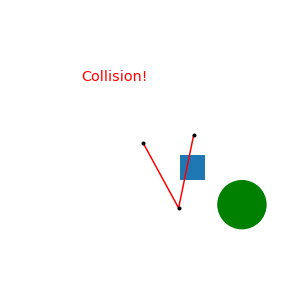

In [218]:
fig = plt.figure(figsize=(5, 5))

for ntrials in range(10):
    
    state = initial_state(robot)
    state = next_state(state, 0)
    action, _ = epsilon_greedy(robot, Qnet, state, 0)
   
    for step in range(100):
        fig.clf()
        robot.plot()
        plt.axis('off')
        state = next_state(state, action)
        r = reinforcement(robot)
        action, _ = epsilon_greedy(robot, Qnet, state, epsilon)
        # print(action)
        if robot.collided:
            plt.text(5, 15, 'Collision!', fontsize='x-large', color='red')
            # plt.pause(1)
        if robot.goal_achieved:
            plt.text(5, 15, 'GOAL!', fontsize='x-large', color='green')
            # plt.pause(1)
        clear_output(wait=True)
        display(fig)
        if robot.collided or robot.goal_achieved:
            break
 
clear_output(wait=True)

## Requirements

Try various values for these parameters to try to finds ones that result in high number of successful runs to reach the goal.

  * hidden layer structure
  * n_trials
  * n_steps_per_trial 
  * n_epochs
  * learning_rate
  
 You can also experiment with a different reinforcement function, but this is optional.

## Extra Credit

Try each of the following modifications, each for 1 extra credit point.

   * Try more links, like 3 or 4.
   * Add one or two more obstacles.
   * Add plotting functions to show a contour plot and surface plot of the maximum Q value over all actions for a set of joint angles for the 2 link arm.  
   
For each of these, try to find good parameter values for which the robot successfully learns to reach the goal reliably.